<a href="https://colab.research.google.com/github/yufengsjtu/DL_learn/blob/main/LeNetBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
from torch import nn
import numpy as np

def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
def evaluate_accuracy_gpu(net,data_iter,device=None):
  if isinstance(net,torch.nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = Accumulator(2)
  for X,y in data_iter:
    if isinstance(X,list):
      X = [x.to(device) for x in X]
    else:
      X = X.to(device)
    y = y.to(device)
    metric.add(accuracy(net(X),y),y.numel())
  return metric[0]/metric[1]

import torchvision
from torch.utils import data
from torchvision import transforms
batch_size = 256
def load_fashion_minst_dataset(batch_size,resize=None):
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(
        root="./sample_data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(
        root="./sample_data", train=False, transform=trans, download=True)
  return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=4),
      data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=4))
  
import matplotlib.pyplot as plt
def train(net,train_iter,test_iter,num_epochs,lr,device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_normal_(m.weight)
  net.apply(init_weights)
  net.to(device)
  print('training on：\t',device)
  optimizer = torch.optim.SGD(net.parameters(),lr=lr)
  loss = nn.CrossEntropyLoss()
  train_loss_display = []
  train_acc_display = []
  test_acc_display = []
  train_index = []
  test_index = []
  num_batches = len(train_iter)
  for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i,(X,y) in enumerate(train_iter):
      optimizer.zero_grad()
      X,y = X.to(device),y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      l.backward()
      optimizer.step()
      metric.add(l * X.shape[0],accuracy(y_hat,y),X.shape[0])
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      train_loss_display.append(train_l)
      train_acc_display.append(train_acc)
      train_index.append(epoch + (i + 1) / num_batches)
    test_acc = evaluate_accuracy_gpu(net,test_iter)
    test_acc_display.append(test_acc)
    test_index.append(epoch + 1)
  plt.plot(train_index,train_loss_display,color='red',label='train loss')
  plt.plot(train_index,train_acc_display,color='green',label='train acc')
  plt.plot(test_index,test_acc_display,color='black',label='test acc')
  plt.legend(loc='upper right')
  plt.show()
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')

lr = 0.9
num_epochs = 10
train_iter,test_iter = load_fashion_minst_dataset(batch_size)
def try_gpu(i=0):
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [2]:
class BatchNorm(nn.Module):
  def __init__(self,num_features,num_dim):
    super().__init__()
    if num_dim == 2:                 #full connect
      shape = (1,num_features)
    elif num_dim == 4:
      shape = (1,num_features,1,1)
    else:
      assert (num_dim==2 or num_dim==4),f'para num_dim wrongly set'
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self,X):
    # 如果X不在内存上，将moving_mean和moving_var
    # 复制到X所在显存上
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    # 保存更新过的moving_mean和moving_var
    Y, self.moving_mean, self.moving_var = self.batch_norm(
        X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
        )
    return Y
     
  def batch_norm(self,X,gamma,beta,moving_mean,moving_var,eps,momentum):
    if not torch.is_grad_enabled:
      X_hat = (X - moving_mean) / torch.sqrt( moving_var + eps )
    else:
      assert len(X.shape) in (2,4)
      if len(X.shape) == 2:
        mean = X.mean(dim=0)
        var = ((X - mean)**2).mean(dim=0)
      else:
        mean = X.mean(dim=(0,2,3),keepdim=True)
        var = ((X - mean)**2).mean(dim=(0,2,3),keepdim=True)
      X_hat = (X - mean) / torch.sqrt( var + eps )
      moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
      moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y,moving_mean.data,moving_var.data

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dim=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dim=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dim=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dim=2), nn.Sigmoid(),
    nn.Linear(84, 10))

training on：	 cuda:0


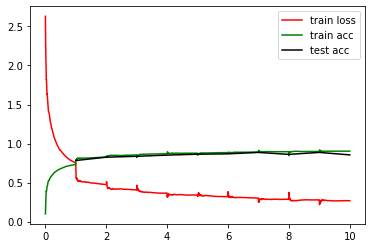

loss 0.267, train acc 0.902, test acc 0.854


In [8]:
lr, num_epochs, batch_size = 1.0, 10, 256
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())